In [1]:
"""Propagating 2D dynamics on the muller potential using OpenMM.
Currently, we just put a harmonic restraint on the z coordinate,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
"""
from openmm.unit import kelvin, picosecond, femtosecond, nanometer, dalton
import openmm as mm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import MullerForce, ModifiedMullerForce, landscape
from muller_utils import (ObsBoundReInit, random_init_point, target_init_point,
                          find_region_change, deepest_well_escape_frame)

import os, tqdm, pickle, yaml
from datetime import datetime

# Parameter Set-up

In [2]:
# random start or target start
start_mode = 'target'

In [3]:
# Get the current time
current_time = datetime.now()
formatted_time = current_time.strftime('%y%m%d_%H%M')
directory = f"results/mod_muller/ogn/{start_mode}_{formatted_time}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
# Observation Guided Navigation parameters
random_seed = 1
np.random.seed(random_seed)
total_step = 20000       # total number of steps
large_batch_size = 500  # number of steps for outer loop
small_batch_size = 50   # number of steps for inner loop (scout)
k = 50.0                # update rate parameter (higher k means smaller update)
boundary_frac = 0.75    # threshold to determine bounday based on the fraction of points in the region


# Brownian simulation parameters
## each particle is totally independent, propagating under the same potential
nParticles = 1  

temp_non_dimensional = 750
mass_non_dimensional = 1.0
friction_non_dimensional = 100
timestep_non_dimensional = 10.0
step = 100
temperature = temp_non_dimensional * kelvin
mass = mass_non_dimensional * dalton
friction = friction_non_dimensional / picosecond
timestep = timestep_non_dimensional * femtosecond


# set up x and y limits for the plot
x_limits = (-3.5, 2.0)
y_limits = (-1.2, 3.5)

# define initial point
if start_mode == 'random':
    init = random_init_point(x_limits, y_limits) # np.array([-0.9, 1.4, np.random.uniform(0, 1)])
elif start_mode == 'target':
    init = target_init_point(-0.9, 1.4)

In [5]:
# Define all other parameters and include them in a dictionary
parameters = {
    'start_mode': start_mode,
    'random_seed': random_seed,
    'total_step': total_step,
    'large_batch_size': large_batch_size,
    'small_batch_size': small_batch_size,
    'k': k,
    'boundary_frac': boundary_frac,
    'nParticles': nParticles,
    'mass': mass_non_dimensional,
    'temperature': temp_non_dimensional,
    'friction': friction_non_dimensional,
    'timestep': timestep_non_dimensional,
    'step': step,
}


# Serialize and save as a YAML file

with open(os.path.join(directory, 'param.yaml'), 'w') as file:
    yaml.dump(parameters, file)

# Run simulation

In [6]:
# Brownian simulation set-up
system = mm.System()
pes = landscape('Modified_Muller')

for i in range(nParticles):
    system.addParticle(mass)
    pes.addParticle(i, [])
system.addForce(pes)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)

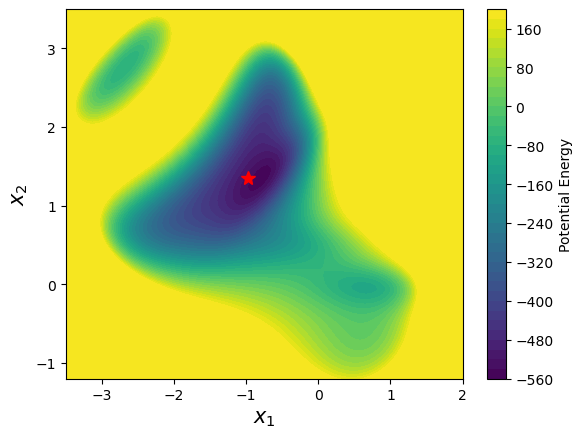

In [7]:
ft = 15
e = 0.2
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.plot(init[:, 0], init[:, 1], '*', color='r', markersize=10)
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.show()

1 outer step: 500   | cent: [-0.81  1.35] | init: [-0.98  1.36]
    inner step: 600 | cent: [-0.82  1.35] | init: [-0.03  0.73] |  v_n: 2.0 | update: 1.02
    inner step: 800 | cent: [-0.8   1.37] | init: [-0.83  2.34] |  v_n: 6.0 | update: 1.1
    inner step: 1000 | cent: [-0.81  1.37] | init: [-1.92  1.54] |  v_n: 10.0 | update: 1.18
    inner step: 1200 | cent: [-0.83  1.34] | init: [-2.29  1.29] |  v_n: 14.0 | update: 1.26
    inner step: 1400 | cent: [-0.8   1.36] | init: [-0.83  2.64] |  v_n: 18.0 | update: 1.34
    inner step: 1600 | cent: [0.47 0.12] | init: [-0.51 -0.07] |  v_n: 22.0 | update: 1.42
2 outer step: 2100   | cent: [-0.82  1.35] | init: [-0.82  1.31]
    inner step: 2200 | cent: [-0.83  1.32] | init: [-0.08  2.07] |  v_n: 2.0 | update: 1.02
    inner step: 2400 | cent: [-0.82  1.35] | init: [-1.87  1.46] |  v_n: 6.0 | update: 1.1
    inner step: 2600 | cent: [-0.8   1.37] | init: [0.2 2.1] |  v_n: 10.0 | update: 1.18
    inner step: 2800 | cent: [-0.81  1.36] | ini

/home/hoon/boltzmann/OGN/energy_landscape.py:136: RuntimeWarning: overflow encountered in exp
  value += self.AA[j] * np.exp(self.aa[j] * (x - self.XX[j])**2 + \


11 outer step: 16850   | cent: [ 0.62 -0.04] | init: [ 0.65 -0.02]
12 outer step: 17450   | cent: [-0.81  1.36] | init: [-0.96  1.14]
    inner step: 17600 | cent: [-0.8   1.38] | init: [-0.15  0.61] |  v_n: 3.0 | update: 1.04
    inner step: 17800 | cent: [-0.81  1.36] | init: [-0.61  2.56] |  v_n: 7.0 | update: 1.12
    inner step: 18000 | cent: [-0.82  1.36] | init: [-0.92  2.56] |  v_n: 11.0 | update: 1.2
    inner step: 18200 | cent: [-0.8   1.36] | init: [-1.63  2.28] |  v_n: 15.0 | update: 1.28
    inner step: 18400 | cent: [-0.83  1.34] | init: [-2.28  1.55] |  v_n: 19.0 | update: 1.36
    inner step: 18600 | cent: [-0.8   1.37] | init: [-1.63  2.56] |  v_n: 23.0 | update: 1.44
13 outer step: 19250   | cent: [ 0.62 -0.04] | init: [ 0.69 -0.04]
14 outer step: 19850   | cent: [-0.82  1.35] | init: [-0.76  1.47]
    inner step: 20000 | cent: [-0.8   1.36] | init: [-0.08  0.72] |  v_n: 3.0 | update: 1.04
itertation number matching!!


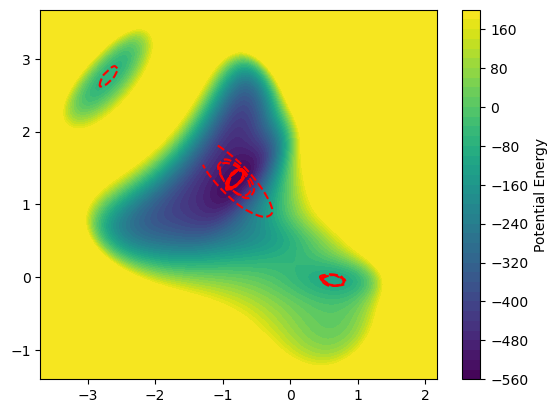

In [8]:
# Preparation to run simulations
traj_outer_save = []
traj_all_save = []
init_points_outer = []
init_points_inner = []
update_pos = []
update_rates = []
v_save = []
cent = init[:,:2].T 
v = 0
iteration_counter = {}
startingPositions = init
#########################


# Plot the energy landscape
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

# Start simulation
remain_step = total_step
n=1 # outer loop counter

while remain_step > 0:
    # Initialization    
    context.setPositions(startingPositions)
    context.setVelocitiesToTemperature(temperature)
    init_points_outer.append(startingPositions[0][:2])
    
    # Outer iteration (Run Browninan Simulation)
    traj = np.zeros((large_batch_size,3))
    for i in range(large_batch_size):
        x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
        p = x[0]
        E = pes.potential(x=p[0], y=p[1])
        traj[i] = np.array([p[0], p[1], E])
        integrator.step(step)
    traj_all_save.append(traj)
    
    # Instantiation
    particle_outer = ObsBoundReInit(traj, cent_prev=cent, inc_prev=v,
                                    delta=0.0001, k=k)
    
    # Secure boundary & centroid & last point & kernel (density gradient)
    # to determine whether the next centroid is inside the boundary
    boundary_path = particle_outer.get_contour_path(target_fraction=boundary_frac)
    kde_outer = particle_outer.kde()
    
    cent = particle_outer.cent
    last = particle_outer.last
    remain_step -= large_batch_size # step counter

    # print results
    print(f'{n} outer step: {total_step-remain_step}   | cent: {np.round(cent.flatten(),2)} \
| init: {np.round(init_points_outer[-1],2)}')

    # Decision block 
    ## Determine whether the centroid inside any boundary paths 
    ## Start inner loop after the decision
    ## If the centroid is outside all boundary paths, this while loop would be skipped!
    m=0 # inner loop counter
    while (particle_outer.increase(boundary_path, cent) != 0) and (remain_step > 0):
        # Instantiation
        particle_inner = ObsBoundReInit(traj, cent_prev=cent, inc_prev=v,
                                        delta=0.0001, k=k)
  
        # Update reinitialization point
        ## Update rate is amplified by the number of times the centroid is revisited
        density_grad = particle_inner.density_gradient(point=last, kde=kde_outer)
        p_new, upd = particle_inner.update_position(grad=density_grad, vn=v) 
        E_new = pes.potential(*p_new)
        startingPositions = np.vstack((p_new, E_new)).T
        
        # Save update rate for tracking 
        update_rates.append(upd)
        update_pos.append((last.reshape(2), p_new.reshape(2)))

        # Re-Initialization
        context.setPositions(startingPositions)
        context.setVelocitiesToTemperature(temperature)       
        init_points_inner.append(startingPositions[0][:2])
        # Inner iteration (Run Brownian Simulation)
        traj = np.zeros((small_batch_size,3))
        for i in range(small_batch_size):
            x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
            p = x[0]
            E = pes.potential(x=p[0], y=p[1])
            traj[i] = np.array([p[0], p[1], E]) 
            integrator.step(step)
        traj_all_save.append(traj)
    
        # Secure centroid & last point & v_n for the next run
        v_save.append(v)
        v += 1.0      
        cent = particle_inner.cent
        last = particle_inner.last    
        remain_step -= small_batch_size
        # print results
        if (remain_step%200 == 0): #or (boundary_path.contains_point(cent) == False):
            print(f'    inner step: {total_step-remain_step} | cent: {np.round(cent.flatten(),2)} | \
init: {np.round(startingPositions[0][:2],2)} |  v_n: {v} | update: {np.round(upd,2)}')
        
        m+=1
        
        if remain_step < 0:
            print('reached the max step')
            break
            
    # Reset v_n & init point 
    ## init point as last traj from newly found cluster 
    iteration_counter.update({n:m}) 
    v=0 # update rate reset 
    p_new = last # last point as the new initial point
    E_new = pes.potential(*p_new)
    startingPositions = np.vstack((p_new, E_new)).T
    n+=1

if np.sum(list(iteration_counter.values())) == len(update_rates):
    print('itertation number matching!!') 
else:
    print('iteration number NOT matching!!')

In [9]:
# deep well escape frame
transition_frame = find_region_change(traj_all_save)
dwef = deepest_well_escape_frame(iteration_counter, large_batch_size, small_batch_size)
print(f'deep well escape frame: {dwef} | transition frame: {transition_frame}')

deep well escape frame: 1550 | transition frame: 1550


In [10]:
# Combine the lists into one dictionary and include iteration_counter as a nested dictionary
result = {
    'init': init,
    'traj_outer_save': traj_outer_save,
    'traj_all_save': traj_all_save,
    'init_points_outer': init_points_outer,
    'init_points_inner': init_points_inner,
    'update_pos': update_pos,
    'update_rates': update_rates,
    'v_save': v_save,
    'iteration_counter': iteration_counter,  # Include iteration_counter as a nested dictionary
    'dwef': dwef,
}

# save the result into pickle
with open(os.path.join(directory, 'result.pkl'), 'wb') as file:
    pickle.dump(result, file)

# Update rate

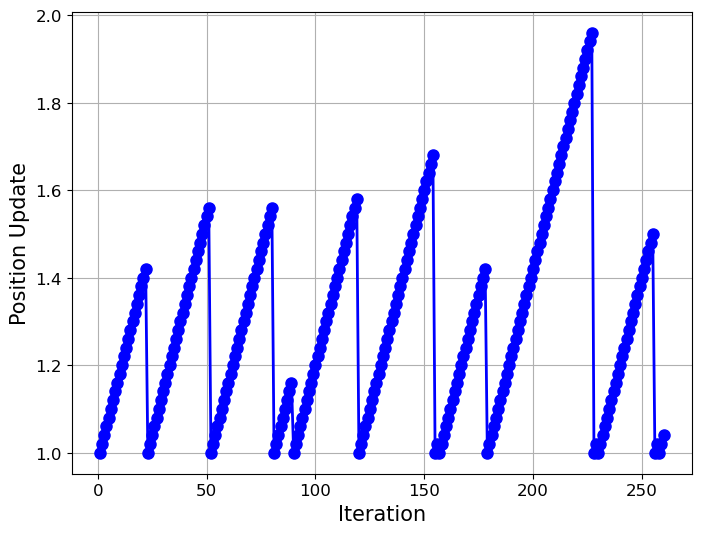

In [11]:
# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
iteration = np.arange(1, len(update_rates) + 1)
plt.plot(iteration, update_rates, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Add labels and title
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Position Update', fontsize=15)
# plt.title('Position Update vs. Iteration', fontsize=16)

# Increase the tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Save the plot as an image (optional)
plt.savefig(os.path.join(directory, 'update_rate.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Outer loop data points

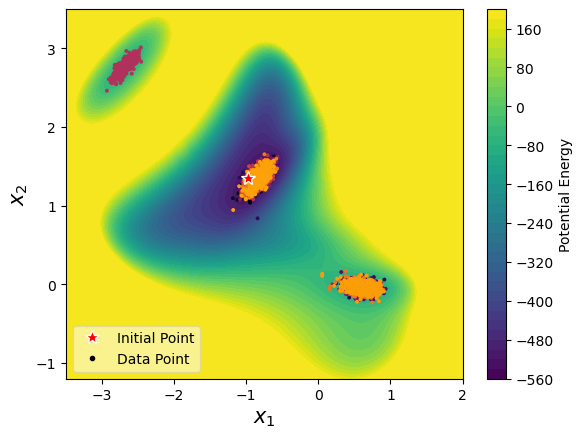

In [65]:
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

# derive outer loop index from iteration counter
outer_index = [0]
current_sum = 0
for key, value in sorted(iteration_counter.items())[:-1]:
    current_sum += (value + 1)
    outer_index.append(current_sum)

outer_index = np.array(outer_index)


colors = cm.inferno(np.linspace(0, 0.8, len(traj_all_save)))
plt.plot(init[:, 0], init[:, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
for n in outer_index: 
    # print(n)
    c = colors[n]
    x = traj_all_save[n][:,0]
    y = traj_all_save[n][:,1]
    plt.scatter(x, y, edgecolor='none', s=8, color=c) #, label=f'Run {n+1}')

plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.plot([], [], '.', c='k', label='Data Point')  # 'o' for circle markers

plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)
plt.savefig(os.path.join(directory,'outer_points.png'), bbox_inches='tight', facecolor='w')
plt.show()

# All data points

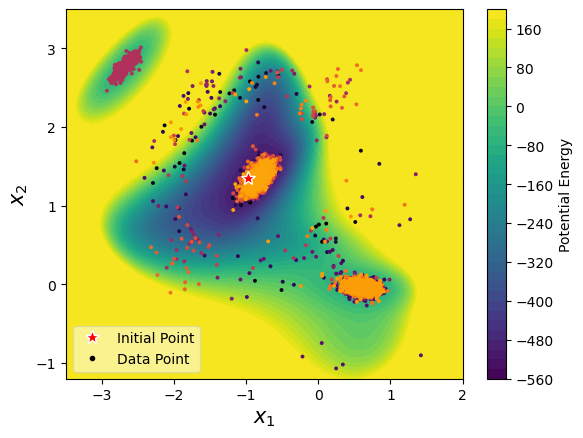

In [62]:
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

colors = cm.inferno(np.linspace(0, 0.8, len(traj_all_save)))
plt.plot(init[:, 0], init[:, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
i=0
for n in range(len(traj_all_save)): 
    c = colors[n]
    x = traj_all_save[n][:,0]
    y = traj_all_save[n][:,1]
    plt.scatter(x, y, edgecolor='none', s=8, color=c) #, label=f'Run {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])

# plt.plot([], [], '*', c='r', label='Initial Point')
plt.plot([], [], '.', c='k', label='Data Point')  # 'o' for circle markers

plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)

# plt.legend(fontsize=ft-5, loc='lower left')
plt.savefig(os.path.join(directory,'all_points.png'), bbox_inches='tight', facecolor='w')
plt.show()

# Update arrows

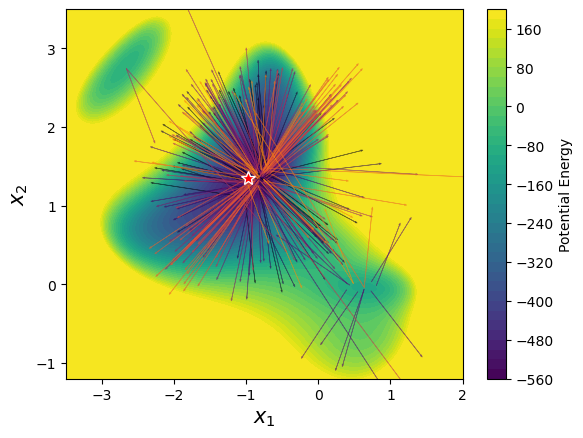

In [60]:
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.plot(init[:, 0], init[:, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
for n in range(len(update_pos)): 
    c = colors[n]
    x_prev, y_prev = update_pos[n][0]
    x_upd, y_upd = update_pos[n][1]
    plt.arrow(x_prev, y_prev, x_upd-x_prev, y_upd-y_prev, 
              color=c, head_width = .02, linewidth=0.5, alpha=0.5)

    i += 1

plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
# plt.plot([], [], '*', c='r', label='Initial Point')
# plt.arrow([], [], [], [], head_width = .02, linewidth=0.5, alpha=0.5, c='k', label='Update Direction')  # 'ms' for square markers
# plt.plot([], [], '.', c='k', label='Initial Points for Each Run')  # 'o' for circle markers
# plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)
# plt.savefig(f'./figure/0320/mod_muller_update_i{iteration}bs{batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.savefig(os.path.join(directory,'arrows.png'), bbox_inches='tight', facecolor='w')
plt.show()

# Initial points

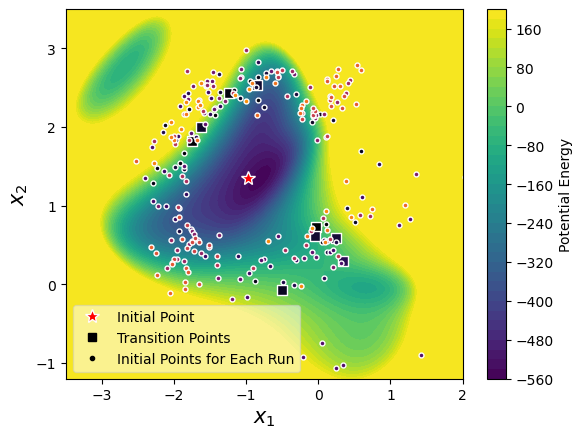

In [63]:
# get transition index
inner_points = np.array(init_points_inner)
transition_index = np.array(list(iteration_counter.values()))-1

pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.plot(init[:, 0], init[:, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
i=0
for n in range(len(init_points_inner)): 
    c = colors[n]
    x = init_points_inner[n][0]
    y = init_points_inner[n][1]
    if n in transition_index:
        plt.scatter(x, y, edgecolor='white', s=50, marker='s', color=c) #, label=f'Run {i+1}')
    else:
        plt.scatter(x, y, edgecolor='white', s=50, marker='.', color=c)
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])


# Dummy plots for legend
plt.plot([], [], 's', c='k', label='Transition Points')  # 'ms' for square markers
plt.plot([], [], '.', c='k', label='Initial Points for Each Run')  # 'o' for circle markers

plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)
plt.savefig(os.path.join(directory,'init_points.png'), bbox_inches='tight', facecolor='w')
plt.show()

# Potential Curve

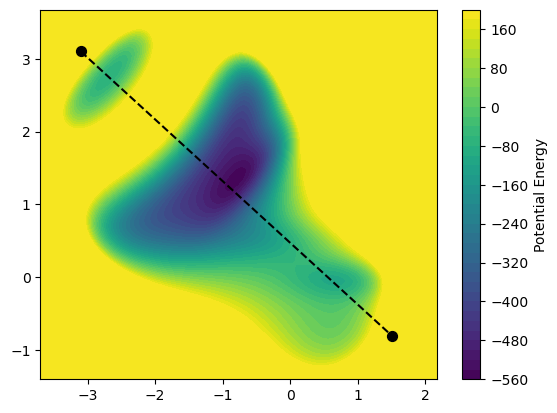

In [24]:
# plot trajectories
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

start_point = (-3.1, 3.1)
end_point = (1.5, -0.8)
plt.scatter(start_point[0], start_point[1], marker='o', s=50, color='k')
plt.scatter(end_point[0], end_point[1], marker='o', s=50, color='k')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k--')
plt.savefig(os.path.join(directory,'cutting_plane.png'), bbox_inches='tight', facecolor='w')

In [43]:
traj_all_save[10]

array([[  -1.92299139,    1.54170704,  -48.19011214],
       [  -0.71641296,    1.45493996, -548.64374896],
       [  -0.96335804,    1.37465346, -532.11742026],
       [  -0.78471351,    1.32935786, -553.60812489],
       [  -0.92520618,    1.22458076, -545.39700778],
       [  -0.90475261,    1.25223494, -548.48339243],
       [  -0.82618374,    1.38521147, -552.13444644],
       [  -0.78431493,    1.36266661, -554.64983298],
       [  -0.99418485,    1.25897276, -536.96471863],
       [  -0.78788143,    1.41493392, -552.01710189],
       [  -0.70950133,    1.39647985, -549.49943545],
       [  -1.09913611,    1.21231568, -518.28557295],
       [  -0.74318761,    1.35540128, -551.60822852],
       [  -0.7150811 ,    1.390324  , -550.0259387 ],
       [  -1.01507008,    1.11769438, -527.07523951],
       [  -0.72957844,    1.30488265, -541.96220451],
       [  -0.69363523,    1.46587336, -546.29240282],
       [  -0.71338409,    1.42630661, -550.07465836],
       [  -0.77734923,    1.

In [47]:
start_point[0]

-3.1

In [46]:
traj_all

array([[  -0.98021728,    1.3551122 , -531.23157635],
       [  -0.91692841,    1.29735446, -547.54202417],
       [  -0.80963343,    1.30009949, -552.78205919],
       ...,
       [  -0.89695543,    1.27730823, -549.90158799],
       [  -0.70433825,    1.39441788, -548.6343396 ],
       [  -0.83139914,    1.380831  , -552.05727158]])

In [45]:
traj_all[:,0]

array([-0.98021728, -0.91692841, -0.80963343, ..., -0.89695543,
       -0.70433825, -0.83139914])

(-3.0, 10.0)

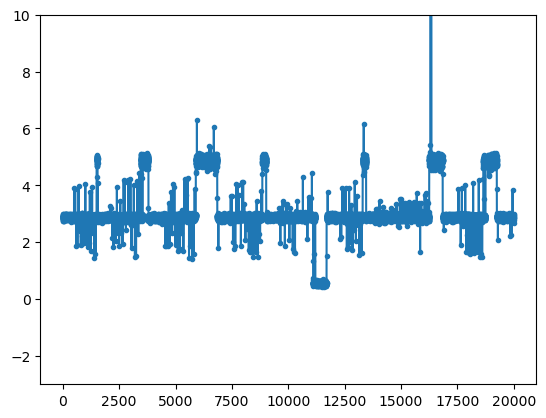

In [54]:
plt.plot(z_all, marker='.') #.std()
plt.ylim(-3,10)

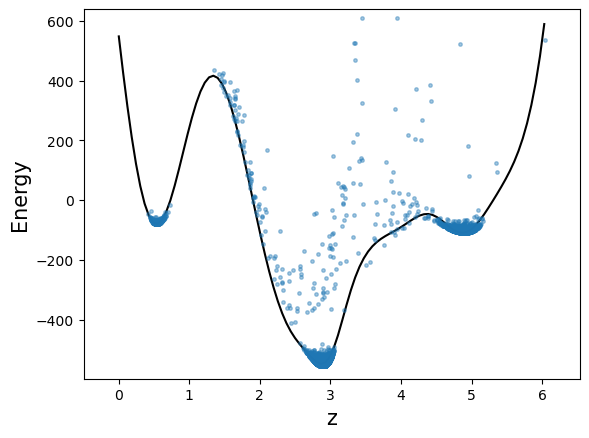

In [29]:
# Determine z values for the cutting plane
traj_all = np.vstack(traj_all_save)
x_all = traj_all[:, 0] - start_point[0]
y_all = traj_all[:, 1] - start_point[1]
E_all = traj_all[:, 2]
z_all = np.sqrt(x_all**2 + y_all**2)

# Define the number of points you want on the diagonal line
num_points = 100  # You can adjust this number as needed

# Calculate the (x, y) coordinates along the diagonal line
x_values = np.linspace(start_point[0], end_point[0], num_points)
y_values = np.linspace(start_point[1], end_point[1], num_points)
z_values = np.sqrt((x_values-start_point[0])**2+(y_values-start_point[1])**2)
# Calculate energy values for the (x, y) coordinates
muller_force = ModifiedMullerForce()
E_values = muller_force.potential(x_values, y_values)


# Plot the energy curve
plt.plot(z_values, E_values, 'k-')
plt.plot(z_all, E_all, '.', markersize=5, alpha=0.4)


plt.xlim(min(z_values)-0.5, max(z_values)+0.5)
plt.ylim(min(E_values)-50, max(E_values)+50)
# plt.legend(fontsize=ft-5, loc='best')
plt.xlabel('z', fontsize=ft)
plt.ylabel('Energy', fontsize=ft)
plt.savefig(os.path.join(directory,'energy_curve.png'), bbox_inches='tight', facecolor='w')

In [55]:
# Calculate the mean and standard deviation
mean_z = np.mean(z_all)
std_z = np.std(z_all)

# Calculate Z-scores
z_scores = (z_all - mean_z) / std_z

# Filter out outliers
threshold = 3
z_all = z_all[(z_scores > -threshold) & (z_scores < threshold)]

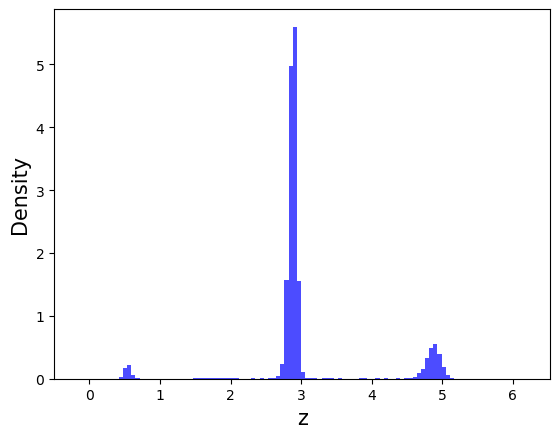

In [56]:
# Plot the distribution
plt.hist(z_all, bins=100, density=True, color='b', alpha=0.7)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Density', fontsize=ft)
# plt.title('Distribution of Distance from Start Point')
# plt.legend(fontsize=ft-5, loc='best')
plt.xlim(min(z_values)-0.5, max(z_values)+0.5)
plt.savefig(os.path.join(directory,'histogram.png'), bbox_inches='tight', facecolor='w')
plt.show()

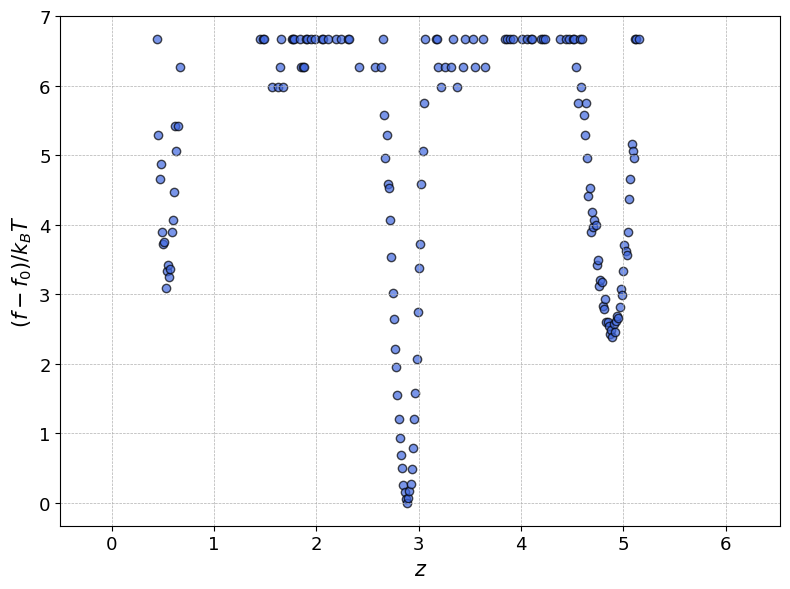

In [57]:
counts, bins = np.histogram(z_all, bins=500)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)

# Making the plot more beautiful
plt.figure(figsize=(8, 6))  # Set figure size


# Visualize the results with improved aesthetics
plt.scatter(anchors, fn, color='royalblue', alpha=0.7, edgecolor='black')

plt.xlabel("$z$", fontsize=ft)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize=ft)
plt.xticks(fontsize=ft-2)
plt.yticks(fontsize=ft-2)
plt.xlim(min(z_values)-0.5, max(z_values)+0.5)
# plt.title('Reconstructed Energy Landscape', fontsize=16)
# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig(os.path.join(directory,'recon_energy_curve.png'), bbox_inches='tight', facecolor='w')
plt.show()